# Primeiros Passos na Segmentação de Imagens Ortomosaicas

## 1. Segmentação das Imagens
O primeiro passo consiste em dividir as imagens ortomosaicas em várias imagens menores de 600x600 pixels, separando todas as camadas (R, G, B) individualmente. Essa etapa é essencial para alimentar o modelo corretamente e otimizar o processamento das imagens.

## 2. Importação de Modelos Pré-treinados e Dataset
Após a segmentação, é necessário importar os modelos pré-treinados e o dataset para realizar inferências (predições). Utilizaremos o modelo **DeepLabV3Plus** com **ResNet-50** treinado para classificação de três classes: **fundo, milho e daninha**.

Repositório do modelo: [DeepLabV3Plus-PyTorch](https://github.com/VainF/DeepLabV3Plus-Pytorch),[weedsgalore](https://github.com/GFZ/weedsgalore)

### 2.1 Análise e Recorte do Dataset
Aqui entra uma parte mais complexa: precisamos analisar o dataset segmentado anteriormente e garantir que nossas imagens estejam devidamente rotuladas. Ferramentas úteis para essa etapa incluem:
- **LabelMe**
- **CVAT**
- **VGG Image Annotator (VIA)**

Essas ferramentas ajudam a criar e validar anotações para treinamento do modelo.

## 3. Fine-tuning ou Transfer Learning
Com as imagens devidamente segmentadas e anotadas, podemos prosseguir para a etapa de **fine-tuning** ou **transfer learning**. Esse processo ajusta o modelo pré-treinado para obter melhor desempenho na segmentação de milho e plantas daninhas, refinando os pesos da rede neural com nosso próprio dataset.

Essa abordagem permite que o modelo se adapte às características específicas das nossas imagens, melhorando sua precisão na segmentação.




* **1** Para atingir esse objetivo, usei Python juntamente com a biblioteca Pillow, que captura uma a uma das imagens .tif e as recorta em blocos de 600x600. Em seguida, ignora as imagens com mais de 10% de alpha e as separa nas camadas RGB, gerando os arquivos nome_imagemR.png, nome_imagemG.png, nome_imagemB.png. As imagens .tif estão localizadas no diretório /imgs/tifs, e as imagens .png são salvas em /imgs/pngs.

In [1]:
#Atualizar dependencias
!pip freeze > requirements.txt

In [ ]:
#Instalar dependencias 
!pip install -r requirements.txt

In [ ]:
import os
from PIL import Image
import numpy as np

# Diretórios
Image.MAX_IMAGE_PIXELS = None
input_dir = './imgs/tifs'  # Diretório com as imagens .tif
output_dir = './imgs/pngs'  # Diretório para salvar as imagens .png

# Função para verificar o alpha da imagem
# def has_high_alpha(img, threshold=0.0):
#     # Obtém o canal alpha, se existir
#     alpha = np.array(img.split()[3]) if img.mode == 'RGBA' else None
#     if alpha is not None:
#         # Calcula a porcentagem de pixels com alpha > 10%
#         alpha_percentage = np.sum(alpha > 10) / alpha.size  # Ajuste o valor 25 conforme necessário
#         return alpha_percentage > threshold
#     return False

import numpy as np
from PIL import Image

def has_high_alpha(img, alpha_threshold=0.1, rgb_threshold=25):
    """
    Verifica se a imagem tem uma alta porcentagem de pixels com baixa opacidade (transparência)
    e valores de RGB baixos.

    Args:
        img (PIL.Image): A imagem a ser analisada.
        alpha_threshold (float): O limiar de porcentagem de pixels com alpha baixo (default 10%).
        rgb_threshold (int): O limiar de opacidade em valores de R, G e B (0-255), abaixo do qual o pixel é considerado transparente (default 25).

    Returns:
        bool: Retorna True se a imagem tiver alta porcentagem de pixels transparentes ou com RGB baixo.
    """
    # Verifica se a imagem tem o canal alpha (RGBA) ou não (RGB)
    if img.mode == 'RGBA':
        # Se for uma imagem RGBA, separa os canais R, G, B e A
        r, g, b, a = img.split()
        r, g, b, a = np.array(r), np.array(g), np.array(b), np.array(a)
    elif img.mode == 'RGB':
        # Se for uma imagem RGB (sem alpha), usa apenas R, G, B e considera alpha como None
        r, g, b = img.split()
        r, g, b = np.array(r), np.array(g), np.array(b)
        a = None
    else:
        # Se a imagem for de outro modo, a função não suporta (por exemplo, imagens em escala de cinza)
        raise ValueError(f"Formato de imagem não suportado: {img.mode}")
    
    # Verifica a porcentagem de pixels com alpha baixo, se houver canal alpha
    if a is not None:
        alpha_percentage = np.sum(a <= 25) / a.size  # Verifica pixels com alpha baixo
    else:
        alpha_percentage = 0

    # Verifica a porcentagem de pixels com RGB baixo (escuro/translúcido)
    low_rgb_pixels = np.sum((r <= rgb_threshold) & (g <= rgb_threshold) & (b <= rgb_threshold)) / r.size

    # Retorna True se a imagem tiver alta porcentagem de transparência ou RGB baixo
    if alpha_percentage > alpha_threshold or low_rgb_pixels > alpha_threshold:
        return True
    return False


# Função para salvar as imagens RGB separadas
# Função para salvar as imagens RGB separadas
def save_rgb_layers(img, base_name):
    # Verifica o modo da imagem
    if img.mode == 'RGB':
        r, g, b = img.split()  # Divide a imagem em suas camadas RGB
    elif img.mode == 'RGBA':
        r, g, b, a = img.split()  # Se a imagem tem canal alpha, divide também
    else:
        # Caso a imagem tenha outro modo, não processa (por exemplo, 'L' para escala de cinza)
        print(f"Imagem no modo {img.mode} não é suportada para divisão RGB.")
        return

    # Converte as camadas para o modo correto antes de salvar
    r = r.convert('RGB')
    g = g.convert('RGB')
    b = b.convert('RGB')

    # Salva cada camada como uma imagem separada
    r.save(os.path.join(output_dir, f"{base_name}R.png"))
    g.save(os.path.join(output_dir, f"{base_name}G.png"))
    b.save(os.path.join(output_dir, f"{base_name}B.png"))
    



# Função para processar as imagens
def process_images():
    # Cria o diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)

    # Itera sobre todas as imagens no diretório de entrada
    qtdImgs = len(os.listdir(input_dir))
    for atual,filename in enumerate(os.listdir(input_dir)):
        if filename.endswith('.tif'):
            file_path = os.path.join(input_dir, filename)
            img = Image.open(file_path)
            
            # Processa a imagem em blocos de 600x600
            partesAproveitadas = 0
            partesPerdidas = 0
            img_width, img_height = img.size
            total = len(list(range(0, img_width, 600))) * len(list(range(0, img_height, 600)))
            for eixoX, i in enumerate(range(0, img_width, 600)):
                for eixoY, j in enumerate(range(0, img_height, 600)):
                    # Define as coordenadas do bloco
                    box = (i, j, min(i + 600, img_width), min(j + 600, img_height))
                    cropped_img = img.crop(box)
                    
                    # Cria um nome base para o arquivo
                    base_name = f"{filename.split('.')[0]}_{i}_{j}_"
                    
                    # Verifica se a parte da imagem tem alta transparência
                    if has_high_alpha(cropped_img,alpha_threshold=0):
                        partesPerdidas += 1
                    else:
                        # Salva as camadas RGB separadas
                        save_rgb_layers(cropped_img, f'{base_name}{eixoX}X{eixoY}')
                        partesAproveitadas += 1
                    
                    # Exibe o progresso a cada iteração
                    progresso = ((eixoX * len(list(range(0, img_height, 600))) + eixoY) / total) * 100
                    print(f'Progresso {eixoX * len(list(range(0, img_height, 600))) + eixoY}/{total} --- {progresso:.2f}% --- Imagen {atual+1}/{qtdImgs}')

            print(f"Foram aproveitadas um total de {partesAproveitadas} imagens e {partesPerdidas} foram perdidas devido ao alto alpha.")

# Executa o processamento
if __name__ == "__main__":
    process_images()


![demostrativo.jpeg](imgs\demostrativoImagensCriadas.jpeg)

4.392 imagens criadas com o codigo acima sendo no caso 1.464 partes utilizaveis, as mesmas seguem o padrao "{nome_original}\_{x}\_{y}\_{paleta}.png" assim como demostrado no codigo 

* **2** Como descrito acima, agora vamos importar os modelos pré-treinados [linkModelos](https://www.dropbox.com/scl/fo/i4k86qqiuzy33aawug287/ABz2JiKdDqjwvDDzMHpeKZI?rlkey=fgm7rgpeankeh9394j492sxif&e=1&dl=0), "Este mesmo link e disponibilizado pelo proprio git do DeepLabV3", logo tentar realizar uma inferência a partir deles. O passo a passo e exatamente o mesmo do descrito no proprio repositorio

In [ ]:
import torch
import network.modeling  
MODEL_NAME = 'deeplabv3_plus_resnet50'  
NUM_CLASSES = 21
OUTPUT_STRIDE = 16
PATH_TO_PTH = './modelos/best_deeplabv3plus_resnet50_voc_os16.pth' 
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load(PATH_TO_PTH)['model_state'])

* **2.1** Com base nisso agr fica mais facil usar o [weedsgalore](https://github.com/GFZ/weedsgalore), rede baseada no [DeepLabV3Plus-PyTorch](https://github.com/VainF/DeepLabV3Plus-Pytorch) continuamos pois o passo a passo


In [9]:
!python weedsgalore-main/src/evaluate.py --dataset_path ./data_weedsgalore/weedsgalore-dataset --split test --ckpt ./modelos/ckpts/dlv3p_rgb_3.pth --in_channels 3 --num_classes 3

Using cpu

             Overall scores             
Split: test
mIoU: 79.33%
iou bg: 97.97%
iou crop: 67.93%
iou weed_1: 72.08%
ECE: 0.005791609175503254


weedsgalore-main/src/evaluate.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_weights_dir, map_location=device)


* **2.2** Com base nisso vamos personalizar mais essa brincadeira

In [7]:
import torch
from myScripts.myModelWeightsDir import Model 

model = Model() 
PATH_TO_PTH = './modelos/ckpts/dlv3p_rgb_3.pth'
state_dict = torch.load(PATH_TO_PTH, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(state_dict)

# Coloque o modelo em modo de avaliação
model.eval()

ModuleNotFoundError: No module named 'torch'

* **2.3** Agora so nos resta realizar uma inferencia 

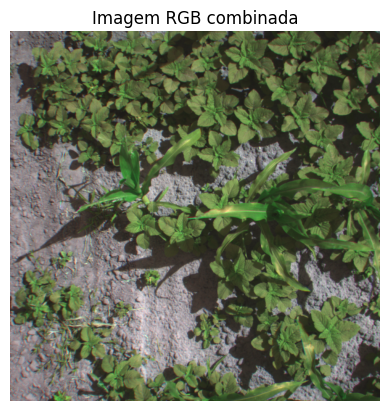

Shape da saída: (1, 3, 600, 600)
Valores mínimos e máximos: -12.390578 10.749633


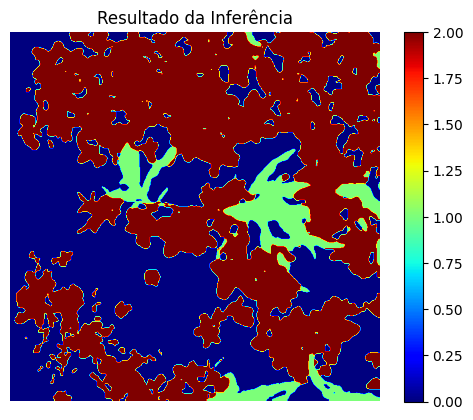

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
def inferencia_modelo(pathR = './data_weedsgalore/weedsgalore-dataset/2023-06-15/images/2023-06-15_0735_R.png',
                      pathG = './data_weedsgalore/weedsgalore-dataset/2023-06-15/images/2023-06-15_0735_G.png',
                      pathB = './data_weedsgalore/weedsgalore-dataset/2023-06-15/images/2023-06-15_0735_B.png',
                      model = model
                      ):
    image_R = cv2.imread(pathR, cv2.IMREAD_GRAYSCALE)
    image_G = cv2.imread(pathG, cv2.IMREAD_GRAYSCALE)
    image_B = cv2.imread(pathB, cv2.IMREAD_GRAYSCALE)
    if image_R is None or image_G is None or image_B is None:
        raise ValueError("Erro ao carregar uma ou mais imagens.")

    # Combinar as imagens R, G, B em um array de 3 canais
    rgb_image = cv2.merge([image_R, image_G, image_B])  # Junta os canais para formar uma imagem RGB

    # Exibir a imagem RGB combinada
    plt.imshow(rgb_image)  
    plt.title('Imagem RGB combinada')
    plt.axis('off')
    plt.show()

    # Transformação para o modelo (sem normalização por enquanto)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converte para tensor
    ])

    # Pré-processar a imagem
    input_image = transform(rgb_image).unsqueeze(0)  # Adiciona dimensão extra para batch (1, C, H, W)

    # Verificar o dispositivo (GPU ou CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_image = input_image.to(device)

    # Certifique-se de que o modelo está no dispositivo correto
    model = model.to(device)

    # Colocar o modelo em modo de avaliação
    model.eval()

    # Realizar a inferência
    with torch.no_grad():
        output = model(input_image)  # Saída do modelo

    # Verificando a saída antes de aplicar argmax
    output_numpy = output.cpu().numpy()
    print("Shape da saída:", output_numpy.shape)  # Deve ser algo como (1, num_classes, H, W)
    print("Valores mínimos e máximos:", output_numpy.min(), output_numpy.max())

    # Se o modelo for de segmentação, obter a máscara final
    output_predictions = output[0]  # Remove a dimensão do batch
    output_predictions = torch.argmax(output_predictions, dim=0)  # Pega a classe mais provável por pixel

    # Converter a saída para imagem
    output_image = output_predictions.cpu().numpy().astype(np.uint8)
    
    # Exibir a imagem de saída (se for uma máscara de segmentação)
    plt.imshow(output_image, cmap="jet")  # Usar cmap para melhor visualização
    plt.colorbar()  # Mostrar escala de cores
    plt.title('Resultado da Inferência')
    plt.axis('off')
    plt.show()
if __name__ == '__main__':
    inferencia_modelo()

* **2.4** Apesar do belo resultado com o proprio dataset, o resultado com imagens proprias nao e muito agradavel:

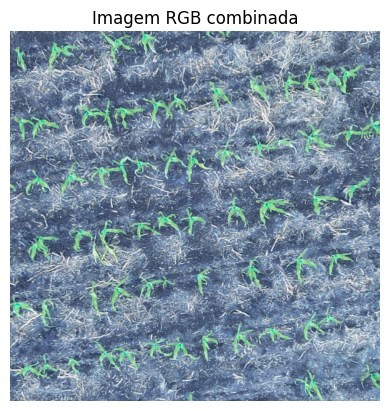

Shape da saída: (1, 3, 600, 600)
Valores mínimos e máximos: -10.254091 10.144181


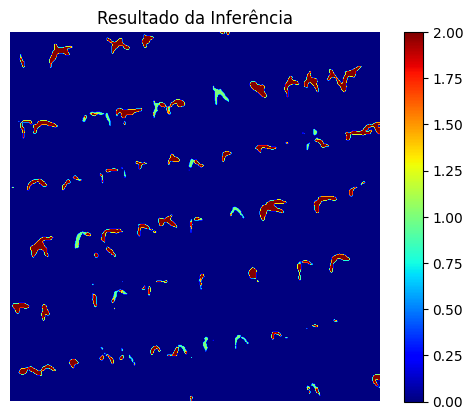

In [6]:
inferencia_modelo(
    './imgs/pngs/Pinhao_28800_2400_48X4R.png',
    './imgs/pngs/Pinhao_28800_2400_48X4G.png',
    './imgs/pngs/Pinhao_28800_2400_48X4B.png',
)

* **3** Sem desânimo! Vamos tentar melhorar esse resultado com um fine-tuning. Para isso, primeiro precisamos rotular nosso dataset. Antes de iniciar a rotulação

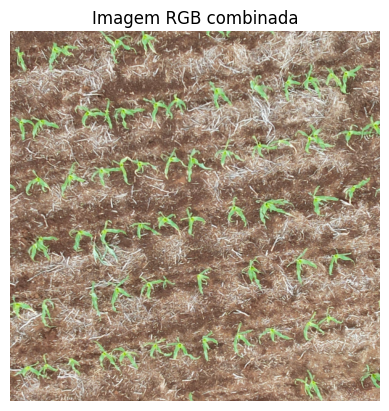

In [2]:
import cv2
import matplotlib.pyplot as plt
def flattenImage(pathR,pathG,pathB):
    image_R = cv2.imread(pathR, cv2.IMREAD_GRAYSCALE)
    image_G = cv2.imread(pathG, cv2.IMREAD_GRAYSCALE)
    image_B = cv2.imread(pathB, cv2.IMREAD_GRAYSCALE)
    if image_R is None or image_G is None or image_B is None:
        raise ValueError("Erro ao carregar uma ou mais imagens.")

    # Combinar as imagens R, G, B em um array de 3 canais
    rgb_image = cv2.merge([image_R, image_G, image_B])  # Junta os canais para formar uma imagem RGB

    # Exibir a imagem RGB combinada
    # rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

if __name__ == '__main__':
    rgb_image = flattenImage(
    './imgs/pngs/Pinhao_28800_2400_48X4R.png',
    './imgs/pngs/Pinhao_28800_2400_48X4G.png',
    './imgs/pngs/Pinhao_28800_2400_48X4B.png',
    )
    plt.imshow(rgb_image) 
    plt.title('Imagem RGB combinada')
    plt.axis('off')
    plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
pathImagens = './imgs/pngs'
archives = os.listdir(pathImagens)
images = set([archive.replace('R.','.').replace('G.','.').replace('B.','.') for archive in archives])

for pathR,pathG,pathB,name in [(f'./imgs/pngs/{image.replace('.','R.')}',
                                f'./imgs/pngs/{image.replace('.','G.')}',
                                f'./imgs/pngs/{image.replace('.','B.')}',
                                image) for image in images]:

    Image = flattenImage(pathR,pathG,pathB)
    plt.imshow(Image)
    plt.imsave(f'./imgs/mascs/{name}',Image)
    print(f'./imgs/mascs/{name}')


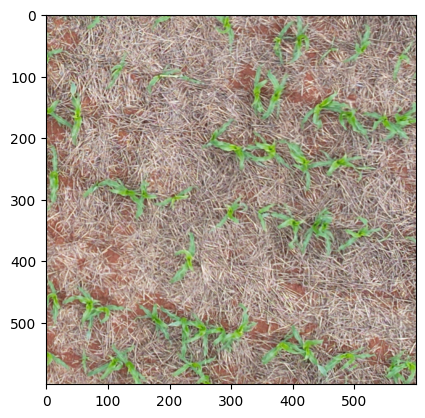

In [ ]:
import cv2
import json
pathImagenTest = './imgs/mascs/Abelardo_luz_1800_67800_3X113.png'
imageTest = cv2.cvtColor(cv2.imread(pathImagenTest), cv2.COLOR_BGR2RGB)

plt.imshow(imageTest)

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
def getSize(image):
    return (600,600)
def createPredict(Obj,old_img,new_img):
    image_name = Obj['filename']
    out_path = new_img
    image_size = getSize(old_img)
    regions = Obj['regions']
    width, height = image_size
    
    # Identificar os tipos únicos e mapear para cores distintas
    unique_types = list(set(region["region_attributes"]["type"] for region in regions))
    type_to_color = {t: int(255 * (i + 1) / len(unique_types)) for i, t in enumerate(unique_types)}
    
    # Criar uma única máscara para todos os tipos
    mask = np.zeros((height, width), dtype=np.uint8)
    maskName = image_name.replace('image','predict')
    pathMask= os.path.join('./mascs/mascarasProntas',maskName)
    if not regions:
        if os.path.exists(pathMask):
            os.remove(pathMask)
            return
        else:
            return
    
    for region in regions:
        shape = region["shape_attributes"]
        all_points_x = shape["all_points_x"]
        all_points_y = shape["all_points_y"]
        pts = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
        
        region_type = region["region_attributes"]["type"]
        color = type_to_color[region_type]
        
        # Preencher o polígono na máscara com a cor correspondente ao tipo
        cv2.fillPoly(mask, pts, color)
    
    # Salvar a máscara
    out_image_path = os.path.join(out_path, f"mask_{os.path.basename(image_name)}")
    # cv2.imwrite(out_image_path, cv2.resize(mask, (width*2, height*2)))
    # print(mask.shape)
    plt.figure(figsize=(10, 10))  # Ajusta o tamanho da figura
    plt.imshow(mask)  # Mostra a imagem
    plt.axis('off')  # Remove os eixos
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove margens
    # plt.show()
    if os.path.exists(pathMask):
        os.remove(pathMask)
    plt.savefig(pathMask)
    plt.close()
    caminho_origem = old_img
    caminho_destino = os.path.join(os.path.dirname(old_img),'mascarasProntas',image_name)
    os.system(f'copy {caminho_origem} {caminho_destino}')
    return mask

In [18]:
import os
import json
path = './mascs'
imgs = [img for img in os.listdir(path) if img.endswith('png')]
json_name = [json_names for json_names in os.listdir(path) if json_names.endswith('json')][0]
json_path = os.path.join(path,json_name)
with open(json_path,'r') as jsonRegions:
    regions = json.load(jsonRegions)
mascaras = list()
total=len(list(enumerate(imgs)))
for i,img in enumerate(imgs):
    for imagen,Obj in regions.items():
        old_img = os.path.join(path,img)
        new_img = old_img.replace('image','pred')
        if img == imagen[:len(img)]:
            # print('Nome imagen:',img)
            # print('Nome no json',imagen)
            # print(old_img)
            # print(new_img)
            # print('------------------')
            mascaras.append({img:createPredict(Obj,old_img,new_img)})
            !cls
            porcentagem = i/total*10
            print('[','#'*int(porcentagem),' '*(10-int(porcentagem)),f"]{int(porcentagem*10)}%")
            



[             ]0%

[             ]0%

[             ]0%
[             ]0%


[             ]0%

[             ]0%
[             ]0%


[             ]0%

[             ]0%

[             ]0%

[             ]0%

[             ]0%
[             ]0%


[             ]0%

[             ]1%

[             ]1%
[             ]1%


[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]1%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]2%

[             ]3%

[             ]3%
[             ]3%


[             ]3%

[             ]3%
[
             ]3%

[             ]3%

[             ]3%


# Data Argumentation
Aqui tratamos de aumentar os dados de treinamento
como a mascara equivale a cada imagem as mesmas alteracoes sao feitas em ambas
## Original -> Vertical
As imagens sao espelhadas verticalmente
## Original -> Horizontal
As imagens sao espelhadas horizontalmente 
## Original -> Rotação (90°, 180°, 270°)
Imagens originais sao rotacionadas em varios angulos diferentes
## Horizontal -> Rotação (90°, 180°, 270°)
Imagens horizontais sao rotacionadas em varios angulos diferentes
## Vertical -> Rotação (90°, 180°, 270°)
Imagens Verticais sao rotacionadas em varios angulos diferentes

In [ ]:
import os
import cv2
import numpy as np

def augment_images(image_paths, output_dir="./dataArgumentation"):
    os.makedirs(output_dir, exist_ok=True)
    
    transformations = {
        "original": lambda img: img,
        "flip_h": lambda img: cv2.flip(img, 1),
        "flip_v": lambda img: cv2.flip(img, 0),
        "flip_hv": lambda img: cv2.flip(img, -1),
    }
    
    rotations = [90, 180, 270]
    
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Erro ao carregar imagem: {img_path}")
            continue
        
        img_name = os.path.basename(img_path)
        name, ext = os.path.splitext(img_name)
        
        for t_name, transform in transformations.items():
            transformed_img = transform(img)
            
            output_path = os.path.join(output_dir, f"{name}_{t_name}{ext}")
            cv2.imwrite(output_path, transformed_img)
            
            for angle in rotations:
                rotated_img = cv2.rotate(transformed_img, {
                    90: cv2.ROTATE_90_CLOCKWISE,
                    180: cv2.ROTATE_180,
                    270: cv2.ROTATE_90_COUNTERCLOCKWISE
                }[angle])
                
                output_path_rot = os.path.join(output_dir, f"{name}_{t_name}_rot{angle}{ext}")
                cv2.imwrite(output_path_rot, rotated_img)
                
    print(f"Processo concluído! Imagens salvas em {output_dir}")
if __name__ == '__main__':
    mascaras,number = [(os.path.join(r'mascs\mascarasProntas',masc),int(masc.split('_')[0])) for masc in os.listdir(r'mascs\mascarasProntas') if masc.endswith('png')]
    
    imagens = [os.path.join(r'mascs',img) for img in os.listdir(r'mascs') if img.endswith('png') and int(img.split('_')[0]) in number]

    print (len(number))

SyntaxError: iterable unpacking cannot be used in comprehension (375302892.py, line 44)